### Rectify all images on S3 bucket and write to public read bucket

In [1]:
from pathlib import Path
import imageio
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil import tz
import pandas as pd

from coastcam_funcs import *
from calibration_crs import *
from rectifier_crs import *

#### Read the inventory of products  
Generated with `aws s3 ls s3://cmgp-coastcam/cameras/caco-01/products/ --profile coastcam > caco01inventory.txt`  
Then edited to remove a few bad entries.
These have beeen deleted from the S3 bucket.

In [2]:
df = pd.read_csv('caco01inventory.txt', header=None, delim_whitespace=True, parse_dates={'datetime': [0, 1]})
df.rename(columns={2:'fid',3:'filename'}, inplace=True)
del df['fid']
df

,datetime,filename
0,2019-12-13 18:45:15,1576260000.c1.snap.jpg
1,2019-12-13 18:45:15,1576260000.c2.snap.jpg
2,2019-12-13 18:45:16,1576260001.c1.timex.jpg
3,2019-12-13 18:45:17,1576260001.c2.timex.jpg
4,2019-12-13 18:45:18,1576260002.c1.var.jpg
...,...,...
103462,2020-11-12 21:01:30,1605213003.c2.bright.jpg
103463,2020-11-12 21:01:31,1605213004.c1.dark.jpg
103464,2020-11-12 21:01:33,1605213004.c2.dark.jpg
103465,2020-11-12 21:01:35,1605213005.c1.rundark.jpg


### Get list of `c1.timex` files and find matching `c2.timex` files. Make list of `c1.timex` images with matches.

In [3]:
# find instances of timex.c1
df2 = df[df['filename'].str.contains('c1.timex')]
df2

,datetime,filename
2,2019-12-13 18:45:16,1576260001.c1.timex.jpg
14,2019-12-13 18:45:24,1576261801.c1.timex.jpg
26,2019-12-13 19:45:09,1576263601.c1.timex.jpg
38,2019-12-13 19:45:15,1576265401.c1.timex.jpg
50,2019-12-13 20:45:09,1576267201.c1.timex.jpg
...,...,...
103409,2020-11-12 19:04:42,1605205801.c1.timex.jpg
103421,2020-11-12 20:00:54,1605207601.c1.timex.jpg
103433,2020-11-12 20:01:14,1605209401.c1.timex.jpg
103445,2020-11-12 21:01:01,1605211201.c1.timex.jpg


In [4]:
filelist = [ ]
matches = 0
no_matches = 0
for i, row in df2.iterrows():
    fs1 = row['filename']
    # print(fs1)
    fn1 = list(fs1)
    fn2 = fn1.copy()
    fn2[12]='2'
    fs2="".join(fn2)
    # print(fs2)
    if len(df[df['filename'].isin([fs2])]) == 1:
        filelist.append(fs1)
        matches += 1
    else:
        no_matches += 1

print(matches, no_matches, matches+no_matches)

8231 761 8992


In [6]:
# setup S3 bucket
imdir='cmgp-coastcam/cameras/caco-01/products/'
fs = fsspec.filesystem('s3',profile='coastcam')

0 1576260001.c1.timex.jpg 2019-12-13 18:00:00 117.62953914068883 2.802980243357476
1 1576261801.c1.timex.jpg 2019-12-13 18:30:00 81.7823326759089 1.809879134890923
2 1576263601.c1.timex.jpg 2019-12-13 19:00:00 78.66385512674037 1.62912669456049
3 1576265401.c1.timex.jpg 2019-12-13 19:30:00 82.35073839241643 1.7079010531726777
4 1576267201.c1.timex.jpg 2019-12-13 20:00:00 83.21176307029974 1.6971691131549282
5 1576269001.c1.timex.jpg 2019-12-13 20:30:00 74.46191146950316 1.4463722318816867
6 1576270801.c1.timex.jpg 2019-12-13 21:00:00 66.00784022511999 1.36606422387401
7 1576272601.c1.timex.jpg 2019-12-13 21:30:00 16.235214732051674 0.25569143491144414
8 1576317601.c1.timex.jpg 2019-12-14 10:00:00 14.386531588818253 0.330585852223569
9 1576319401.c1.timex.jpg 2019-12-14 10:30:00 14.32111699388957 0.31771563352636983
10 1576404001.c1.timex.jpg 2019-12-15 10:00:00 14.502284363723788 0.3276442959930385
11 1576405801.c1.timex.jpg 2019-12-15 10:30:00 14.445317154096882 0.32500889236825153
12

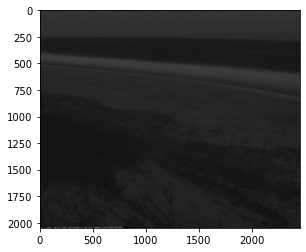

In [9]:
# loop through the filelist and calculate image brightness and sharpness.
for i, fn in enumerate(filelist):
    fpath = imdir+fn
    s = estimate_sharpness(fpath,fs)
    rgb, avg = average_color(fpath,fs)
    ftime, e = filetime2timestr(fn, timezone='eastern')

    print(i,fn,ftime,avg,s)
    if  i == 98:
        with fs.open(fpath,'rb') as f:
            im = Image.open(f).convert('L') # to grayscale
            plt.imshow(im, cmap='gray')
    if i >100:
        break